In [1]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import math
# from util import findCentroid, rotateImage, halveTheRegionHorizontally, computeAsymmetry

from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing
import random
from noise import pnoise2
from PIL import ImageOps
from skimage.color import rgb2lab

# ENV
import os

# ISIC API
import requests
import glob

# Main data structure(s)
import pandas as pd
import numpy as np

# For pi value
import math

# For API calls
import time
import json

# Building a data set
import shutil
import zipfile
from io import BytesIO

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data normalization
from sklearn import preprocessing

# Feature extraction
from skimage import morphology
from skimage.transform import rotate
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

# Color 'brightness' (value) spread

from skimage.measure import regionprops
from skimage.color import rgb2hsv # Converts RGB color to HSV (Hue, Saturation, Value)

# Proper split of training and test data
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

# Model building
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

C:\Users\jackh\AppData\Local\Temp\ipykernel_13864\1469171298.py:52: DeprecationWarning: Please use `mode` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import mode


for selected_images.csv

In [8]:
import os
import pandas as pd

folder_path = '../data/shanon_masks_total'
metadata_path = '../data/metadata.csv'
output_path = '../data/selected_images.csv'

filenames = os.listdir(folder_path)

file_list = [filename for filename in filenames if os.path.isfile(os.path.join(folder_path, filename))]

metadata_df = pd.read_csv(metadata_path)

filtered_metadata = metadata_df[metadata_df['img_id'].isin(file_list)]

filtered_metadata.loc[filtered_metadata['diagnostic'] != 'MEL', 'diagnostic'] = 'NOT'

selected_data = filtered_metadata[['img_id', 'diagnostic', 'patient_id']]

selected_data.to_csv(output_path, index=False)

print(f"Selected images and diagnostic data are saved to: {output_path}")


Selected images and diagnostic data are saved to: ../data/selected_images.csv


Are there duplicate patient_id?

In [9]:
df = pd.read_csv('../data/selected_images.csv')

patient_ids = df['patient_id'].tolist()

duplicates = set([x for x in patient_ids if patient_ids.count(x) > 1])

print(duplicates)

{'PAT_87', 'PAT_194', 'PAT_233', 'PAT_782', 'PAT_262', 'PAT_625', 'PAT_890', 'PAT_719', 'PAT_354', 'PAT_93', 'PAT_486', 'PAT_738', 'PAT_701', 'PAT_270', 'PAT_109', 'PAT_70', 'PAT_656', 'PAT_966', 'PAT_995', 'PAT_115', 'PAT_373', 'PAT_680', 'PAT_801', 'PAT_340', 'PAT_320', 'PAT_771'}


Draw example images for assessment of performance of feature extraction algorithms:

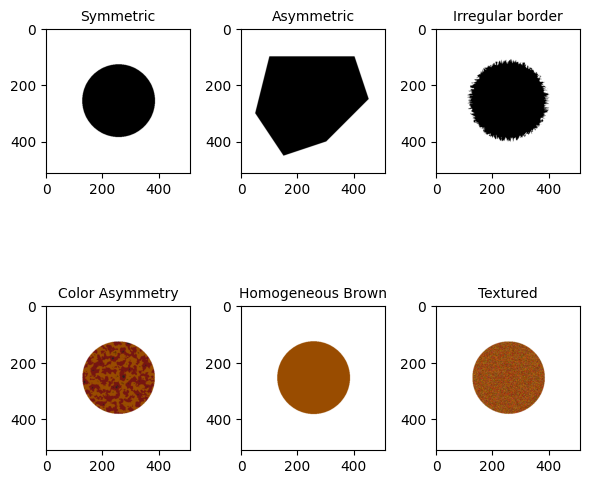

In [33]:
def create_blank_image(width, height, color='white', image_mode='1'):
    return Image.new(image_mode, (width, height), color)

def draw_circle(image, circle_center, circle_radius, color='black'):
    draw = ImageDraw.Draw(image)
    draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
                  circle_center[0] + circle_radius, circle_center[1] + circle_radius),
                 fill=color)

# Create symmetric image
symmetric_img = create_blank_image(512, 512)
draw_circle(symmetric_img, (256, 256), 128)

# Create asymmetric image
asymmetric_img = create_blank_image(512, 512)
draw = ImageDraw.Draw(asymmetric_img)
polygon_points = [(100, 100), (400, 100), (450, 250), (300, 400), (150, 450), (50, 300)]
draw.polygon(polygon_points, fill='black')

# Create irregular image
irregular_img = create_blank_image(512, 512)
draw = ImageDraw.Draw(irregular_img)
circle_center = (256, 256)
radius = radius = min(512, 512) // 2 - 120
num_segments = 500
angle_step = 2 * math.pi / num_segments
points = [(circle_center[0] + (radius + random.uniform(-10, 10)) * math.cos(i * angle_step),
           circle_center[1] + (radius + random.uniform(-10, 10)) * math.sin(i * angle_step))
          for i in range(num_segments)]
draw.polygon(points, fill='black')

# Create color asymmetry image
colorasymmetry_img = create_blank_image(512, 512, image_mode='RGB')
draw = ImageDraw.Draw(colorasymmetry_img)
colors = [(197, 188, 217), (41, 31, 30), (118, 21, 17), (153, 76, 0), (102, 51, 0), (70, 130, 180)]
scale = 0.05
octaves = 4
persistence = 0.5
lacunarity = 2.0
for y in range(512):
    for x in range(512):
        dx = x - circle_center[0]
        dy = y - circle_center[1]
        distance = np.sqrt(dx * dx + dy * dy)
        if distance <= 128:
            noise_val = pnoise2(x * scale, y * scale, octaves, persistence, lacunarity)
            color_idx = int(((noise_val + 1) / 2) * len(colors)) % len(colors)
            draw.point((x, y), fill=colors[color_idx])

# Create homogeneous brown image
homogeneous_brown_img = create_blank_image(512, 512, image_mode='RGB')
draw_circle(homogeneous_brown_img, (256, 256), 128, color=(153, 76, 0))

# Create a textured circle image
def create_textured_circle_image(width, height, circle_center, circle_radius, color=(153, 76, 0), image_mode='RGB'):
    # Create a blank image
    image = Image.new(image_mode, (width, height), 'white')
    draw = ImageDraw.Draw(image)

    # Loop through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center of the circle
            dx = x - circle_center[0]
            dy = y - circle_center[1]
            distance = np.sqrt(dx * dx + dy * dy)

            # If the pixel is inside the circle, set its color with more random noise
            if distance <= circle_radius:
                noise = tuple(int(c + random.gauss(0, 50)) for c in color)  # Add more Gaussian noise to the color
                draw.point((x, y), fill=noise)

    return image

textured_circle_img = create_textured_circle_image(512, 512, (256, 256), 128)

# display all images side by side as Matplotlib figure with title for each image
fig, ax = plt.subplots(2, 3, figsize=(6, 6))
fontsize = 10  # Adjust the font size as desired

ax[0, 0].imshow(symmetric_img, cmap='gray')
ax[0, 0].set_title('Symmetric', fontsize=fontsize)
ax[0, 0].grid(False)  # Remove grid
ax[0, 1].imshow(asymmetric_img, cmap='gray')
ax[0, 1].set_title('Asymmetric', fontsize=fontsize)
ax[0, 1].grid(False)  # Remove grid
ax[0, 2].imshow(irregular_img, cmap='gray')
ax[0, 2].set_title('Irregular border', fontsize=fontsize)
ax[0, 2].grid(False)  # Remove grid
ax[1, 0].imshow(colorasymmetry_img)
ax[1, 0].set_title('Color Asymmetry', fontsize=fontsize)
ax[1, 0].grid(False)  # Remove grid
ax[1, 1].imshow(homogeneous_brown_img)
ax[1, 1].set_title('Homogeneous Brown', fontsize=fontsize)
ax[1, 1].grid(False)  # Remove grid
ax[1, 2].imshow(textured_circle_img)
ax[1, 2].set_title('Textured', fontsize=fontsize)
ax[1, 2].grid(False)  # Remove grid

plt.tight_layout()
plt.show()

Asymmetry score:

In [11]:
def asymmetry_score_1(image_path):
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    width, height = image.size

    area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
    for y in range(height):
        for x in range(width):
            pixel_value = image.getpixel((x, y))
            if pixel_value == 0:  # Black pixel
                if y < height // 2:
                    area_top += 1
                else:
                    area_bottom += 1

                if x < width // 2:
                    area_left += 1
                else:
                    area_right += 1

    vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
    horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

    average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2
    return average_asymmetry

print("Asymmetry score for Symmetric Image:", asymmetry_score_1(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score_1(asymmetric_img))

Asymmetry score for Symmetric Image: 0.004955936517731453
Asymmetry score for Asymmetric Image: 0.09888327467903978


In [12]:
from scipy.ndimage import center_of_mass, rotate

def asymmetry_score_2(image_path, num_rotations=10):
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    image_array = np.array(image)

    center_of_mass_y, center_of_mass_x = center_of_mass(image_array)

    min_asymmetry_score = float('inf')

    for angle in np.linspace(0, 180, num_rotations, endpoint=False):
        rotated_image = rotate(image_array, angle, reshape=False)

        area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
        for y in range(rotated_image.shape[0]):
            for x in range(rotated_image.shape[1]):
                pixel_value = rotated_image[y, x]
                if pixel_value == 0:
                    if y < center_of_mass_y:
                        area_top += 1
                    else:
                        area_bottom += 1

                    if x < center_of_mass_x:
                        area_left += 1
                    else:
                        area_right += 1

        vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
        horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

        average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2

        min_asymmetry_score = min(min_asymmetry_score, average_asymmetry)

    return min_asymmetry_score

print("Asymmetry score for Symmetric Image:", asymmetry_score_2(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score_2(asymmetric_img))

Asymmetry score for Symmetric Image: 0.002151980994385673
Asymmetry score for Asymmetric Image: 0.03195371544242798


Irregular border measurement:

In [13]:
import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing

def border_irregularity_score(image_path):
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')

    mask = np.array(image)

    mask_closed = binary_closing(mask)

    contours = find_contours(mask_closed, 0.5)
    border = max(contours, key=len)

    perimeter = 0
    for i in range(len(border) - 1):
        perimeter += np.linalg.norm(border[i + 1] - border[i])

    area = np.sum(mask)

    irregularity_score = perimeter / area
    return irregularity_score

print("Border irregularity score / Smooth:", border_irregularity_score(symmetric_img))
print("Border irregularity score / Irregular:", border_irregularity_score(irregular_img))

Border irregularity score / Smooth: 0.0040472901122593306
Border irregularity score / Irregular: 0.00938548154508692


Color irregularity measurement

In [14]:
def color_asymmetry_1(image):
    lab_image = rgb2lab(image)

    height, width, _ = image.shape

    block_size = 3
    num_blocks_x = width // block_size
    num_blocks_y = height // block_size

    color_avgs = []

    for i in range(num_blocks_x):
        for j in range(num_blocks_y):
            block = lab_image[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size, :]

            if np.sum(block[:, :, 0] < 90) >= (0.75 * block_size**2):
                color_avg = np.mean(block, axis=(0, 1))
                color_avgs.append(color_avg)

    variances = np.var(color_avgs, axis=0)
    variance_score = np.mean(variances)
    
    return variance_score

homogeneous_brown_arr = np.array(homogeneous_brown_img)
colorasymmetry_arr = np.array(colorasymmetry_img)

print('Symmetric image:', color_asymmetry_1(homogeneous_brown_arr))
print('Asymmetric image:', color_asymmetry_1(colorasymmetry_arr))


Symmetric image: 0.5281182711691491
Asymmetric image: 61.097137226040765


In [15]:
import numpy as np
from skimage.color import rgb2lab
from skimage.transform import resize

def color_asymmetry_2(image):
    if isinstance(image, str):
        image = np.array(Image.open(image).convert('RGB'))
    elif isinstance(image, np.ndarray): 
        if image.dtype != np.uint8:
            raise ValueError("Invalid image array type. Expected dtype=np.uint8.")
        if image.ndim != 3 or image.shape[2] != 3:
            raise ValueError("Invalid image array shape. Expected shape=(H, W, 3).")
    else:
        raise ValueError("Invalid image type. Accepted types are file path or NumPy array.")

    lab_image = rgb2lab(image)

    lab_image = resize(lab_image, (256, 256), mode='reflect', anti_aliasing=True)

    center_line = lab_image.shape[1] // 2

    left_half = lab_image[:, :center_line]
    right_half = lab_image[:, center_line:]

    right_half_flipped = np.fliplr(right_half)

    diff = np.abs(left_half - right_half_flipped)

    avg_color_diff = np.mean(diff)

    return avg_color_diff

homogeneous_brown_img_array = np.array(homogeneous_brown_img)
colorasymmetry_img_array = np.array(colorasymmetry_img)

print("Color symmetry score for Homogeneous Brown Image:", color_asymmetry_2(homogeneous_brown_img_array))
print("Color symmetry score for Color Asymmetry Image:", color_asymmetry_2(colorasymmetry_img_array))

Color symmetry score for Homogeneous Brown Image: 0.0901330200933926
Color symmetry score for Color Asymmetry Image: 1.7055218806917993


Texture

In [17]:
def texture_score_contrast(image):
    if image.ndim == 3:
        image = rgb2gray(image)

    image = img_as_ubyte(image)

    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]

    return contrast

In [18]:
def texture_score_dissimilarity(image):
    if image.ndim == 3:
        image = rgb2gray(image)

    image = img_as_ubyte(image)

    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]

    return dissimilarity

Trial on two images, one is nevus, one is melanoma

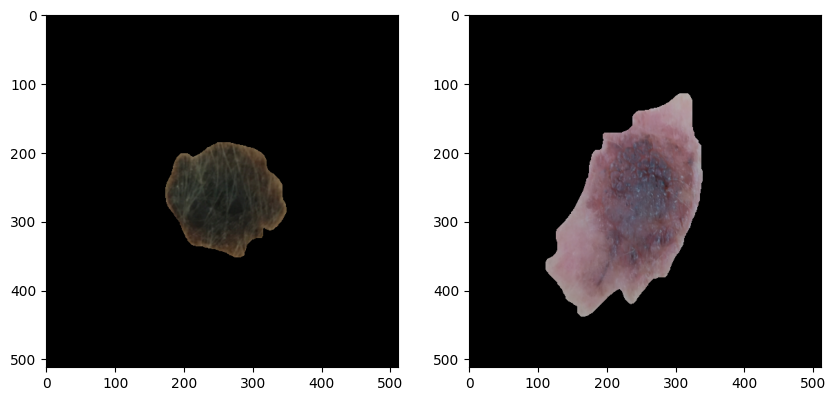

Symmetric image - Asymmetry_score_1: 0.11086770168587484
Asymmetric image - Asymmetry_score_1: 0.22727272727272727
Symmetric image - Asymmetry_score_2: 0.029835922291525964
Asymmetric image - Asymmetry_score_2: 0.07464716687205003
Symmetric image - Border_irregularity_score: 0.0024359869079820847
Asymmetric image - Border_irregularity_score: 0.00440119844074832
Symmetric image - Color_asymmetry_1: 15.446734269655993
Asymmetric image - Color_asymmetry_1: 119.16893179033819
Symmetric image - Color_asymmetry_2: 0.43946373016834817
Asymmetric image - Color_asymmetry_2: 3.1536080587480684
Symmetric image - Texture_score_constrast: 57.248736439842205
Asymmetric image - Texture_score_constrast 325.3891148915188
Symmetric image - Texture_score_dissimilarity: 1.274015347633136
Asymmetric image - Texture_score_dissimilarity: 3.273129314595661


In [19]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def load_masked_image(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image


image_path = '..\\data\\images_resized\\PAT_710_1330_243.PNG'
mask_path = '..\\data\\shanon_masks_total\\PAT_710_1330_243.PNG'
image = Image.open(image_path)
mask = Image.open(mask_path)
masked_image = load_masked_image(image_path, mask_path)
inverted_mask = cv2.bitwise_not(np.array(mask))
masked_image_arr = np.array(masked_image)
gray_image = cv2.cvtColor(masked_image_arr, cv2.COLOR_RGB2GRAY)


image_path1 = '..\\data\\images_resized\\PAT_975_1834_152.PNG'
mask_path1 = '..\\data\\shanon_masks_total\\PAT_975_1834_152.PNG'
image1 = Image.open(image_path1)
mask1 = Image.open(mask_path1)
masked_image1 = load_masked_image(image_path1, mask_path1)
inverted_mask1 = cv2.bitwise_not(np.array(mask1))
masked_image1_arr = np.array(masked_image1)
gray_image1 = cv2.cvtColor(masked_image1_arr, cv2.COLOR_RGB2GRAY)


inverted_mask = Image.fromarray(inverted_mask)
inverted_mask1 = Image.fromarray(inverted_mask1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.subplot(1, 2, 2)
plt.imshow(masked_image1)
plt.show()

print('Symmetric image - Asymmetry_score_1:', asymmetry_score_1(inverted_mask))
print('Asymmetric image - Asymmetry_score_1:', asymmetry_score_1(inverted_mask1))
print('Symmetric image - Asymmetry_score_2:', asymmetry_score_2(inverted_mask))
print('Asymmetric image - Asymmetry_score_2:', asymmetry_score_2(inverted_mask1))
print('Symmetric image - Border_irregularity_score:', border_irregularity_score(inverted_mask))
print('Asymmetric image - Border_irregularity_score:', border_irregularity_score(inverted_mask1))
print('Symmetric image - Color_asymmetry_1:', color_asymmetry_1(masked_image))
print('Asymmetric image - Color_asymmetry_1:', color_asymmetry_1(masked_image1))
print('Symmetric image - Color_asymmetry_2:', color_asymmetry_2(masked_image))
print('Asymmetric image - Color_asymmetry_2:', color_asymmetry_2(masked_image1))
print('Symmetric image - Texture_score_constrast:', texture_score_contrast(gray_image))
print('Asymmetric image - Texture_score_constrast', texture_score_contrast(gray_image1))
print('Symmetric image - Texture_score_dissimilarity:', texture_score_dissimilarity(gray_image))
print('Asymmetric image - Texture_score_dissimilarity:', texture_score_dissimilarity(gray_image1))

Assessment of algorithmic measurements vs. manual measurements for 5 samples as proof of concept

In [20]:
filename = '../data/manual_measurement.csv'

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    data = []
    for row in reader:
        data.append(row[:4])

print(data)

[['PAT_340_714_314.png', '2', '6', '4'], ['PAT_627_1188_503.png', '0', '2', '2.5'], ['PAT_710_1330_243.png', '1', '2', '1'], ['PAT_801_1518_574.png', '1', '4', '3'], ['PAT_975_1834_152.png', '2', '5', '5']]


append algo_asymmetric score to data:

In [21]:
for i in data:
    filename = i[0]
    image_path = os.path.join('../data/Manual_feature_images', filename)
    mask_path = os.path.join('../data/Manual_feature_masks', filename)
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    masked_image = load_masked_image(image_path, mask_path)
    inverted_mask = cv2.bitwise_not(np.array(mask))
    inverted_mask = Image.fromarray(inverted_mask)
    masked_image_arr = np.array(masked_image)
    gray_image = cv2.cvtColor(masked_image_arr, cv2.COLOR_RGB2GRAY)


    asymmetry_1 = asymmetry_score_1(inverted_mask)
    asymmetry_2 = asymmetry_score_2(inverted_mask)
    
    border_irregularity = border_irregularity_score(inverted_mask)
    
    color_asymmetry_score_1 = color_asymmetry_1(masked_image)
    color_asymmetry_score_2 = color_asymmetry_2(masked_image)
    
    texture_contrast_score = texture_score_contrast(gray_image)
    texture_dissimilarity = texture_score_dissimilarity(gray_image)
    
    i.append(asymmetry_1)
    i.append(asymmetry_2)
    i.append(border_irregularity)
    i.append(color_asymmetry_score_1)
    i.append(color_asymmetry_score_2)
    i.append(texture_contrast_score)
    i.append(texture_dissimilarity)

for i in data:
    print(i)


['PAT_340_714_314.png', '2', '6', '4', 0.07407609228723694, 0.029034532543186664, 0.008971265483439825, 73.9445134548536, 3.2775354368610388, 232.79554209812622, 4.412637142504931]
['PAT_627_1188_503.png', '0', '2', '2.5', 0.06350803553460023, 0.03116036301509428, 0.0033949502878729476, 71.35600227397475, 1.8630888516500368, 152.46545241617358, 1.810882026627219]
['PAT_710_1330_243.png', '1', '2', '1', 0.12556681138446696, 0.03311443342182479, 0.0024461762668463974, 15.323729355724494, 0.44438781175686914, 56.13211908284022, 1.2632057445759368]
['PAT_801_1518_574.png', '1', '4', '3', 0.06522427023178547, 0.007183758459135867, 0.0037298512560259797, 28.009709467885358, 1.1090565462119377, 140.52332193047334, 2.1268645216962523]
['PAT_975_1834_152.png', '2', '5', '5', 0.23036497003309775, 0.05658978487772668, 0.0049532805779638304, 122.99400717864451, 3.112112951357824, 337.9096092209073, 3.3701846030572002]


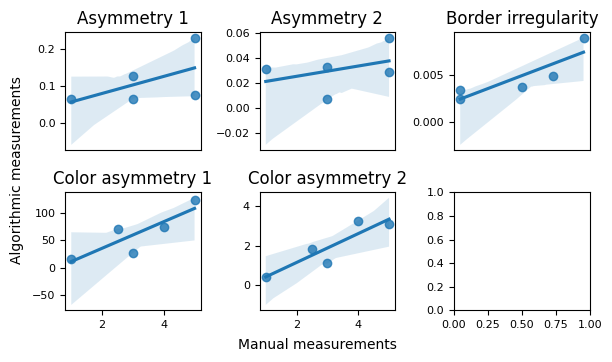

In [54]:
# Extract data from columns
col1 = [float(row[1]) for row in data]  # manual asymmetry
col2 = [float(row[2]) for row in data]  # manual border irregularity
col3 = [float(row[3]) for row in data]  # manual color asymmetry
col4 = [float(row[4]) for row in data]  # asymmetry_1
col5 = [float(row[5]) for row in data]  # asymmetry_2
col6 = [float(row[6]) for row in data]  # border_irregularity
col7 = [float(row[7]) for row in data]  # color_asymmetry_score_1
col8 = [float(row[8]) for row in data]  # color_asymmetry_score_2

fig, axs = plt.subplots(2, 3, figsize=(6, 3.5))

fig.text(0.5, 0, 'Manual measurements', ha='center', va='center')
fig.text(0, 0.5, 'Algorithmic measurements', ha='center', va='center', rotation='vertical')

sns.regplot(x=col1, y=col4, ax=axs[0, 0])
sns.regplot(x=col1, y=col5, ax=axs[0, 1])
sns.regplot(x=col2, y=col6, ax=axs[0, 2])
sns.regplot(x=col3, y=col7, ax=axs[1, 0])
sns.regplot(x=col3, y=col8, ax=axs[1, 1])

axs[0, 0].xaxis.set_ticks([])
axs[0, 1].xaxis.set_ticks([])
axs[0, 2].xaxis.set_ticks([])

axs[0, 0].set_title('Asymmetry 1')
axs[0, 1].set_title('Asymmetry 2')
axs[0, 2].set_title('Border irregularity')
axs[1, 0].set_title('Color asymmetry 1')
axs[1, 1].set_title('Color asymmetry 2')

for ax in axs.flat:
    ax.tick_params(axis='both', which='both', labelsize=8)

plt.tight_layout()
plt.show()


Create a CSV file with all the features

In [23]:
df = pd.read_csv('../data/selected_images.csv')

df_extended = df.copy()
for column in ['asymmetry_1', 'asymmetry_2', 'border_irregularity', 'color_asymmetry_1', 'color_asymmetry_2', 'texture_contrast', 'texture_dissemilarity']:
    df_extended[column] = np.nan  

for i, row in df.iterrows():
    image_path = os.path.join('../data/images_resized', row[0])
    mask_path = os.path.join('../data/shanon_masks_total', row[0])
    
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    masked_image = load_masked_image(image_path, mask_path)
    inverted_mask = cv2.bitwise_not(np.array(mask))
    inverted_mask = Image.fromarray(inverted_mask)
    masked_image_arr = np.array(masked_image)
    gray_image = cv2.cvtColor(masked_image_arr, cv2.COLOR_RGB2GRAY)
    
    df_extended.loc[i, 'asymmetry_1'] = asymmetry_score_1(inverted_mask)
    df_extended.loc[i, 'asymmetry_2'] = asymmetry_score_2(inverted_mask)
    
    df_extended.loc[i, 'border_irregularity'] = border_irregularity_score(inverted_mask)
    
    df_extended.loc[i, 'color_asymmetry_1'] = color_asymmetry_1(masked_image)
    df_extended.loc[i, 'color_asymmetry_2'] = color_asymmetry_2(masked_image)
    
    df_extended.loc[i, 'texture_contrast'] = texture_score_contrast(gray_image)
    df_extended.loc[i, 'texture_dissemilarity'] = texture_score_dissimilarity(gray_image)

df_extended.to_csv('feature_output.csv', index=False)